# Домашнее задание  
## по теме «Линейная регрессия» 

### Импорт библиотек

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
import statsmodels.api as sm
from eda_tools import return_outliers, return_boxplot, return_eda, detect_outliers_iqr

In [2]:
# загрузка DataFrame
df = pd.read_csv('input_data/train.csv') 

### Подготовка исходных данных

In [3]:
df.info(memory_usage=True) # Вывод столбцов и их типов
df.head() # Вывод 5 строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


Выводы. Часть столбцов треуют новых, красивых названий. Часть столбцов требуют измения типа данных на int

In [4]:
# Смена названий столбцов
df.rename(columns={
    'store_sales(in millions)': 'cash_sales',
    'unit_sales(in millions)': 'unit_sales',
    'avg_cars_at home(approx).1': 'avg_cars_home'
}, inplace=True)

### Описание столбцов:
- id	- идентификатор записи
- cash_sales - продажи в мл.долларов_евро_сша 
- unit_sales - продажи в штуках
- total_children - общее кол-во детей
- num_children_at_home - кол-во детей в комнате
- avg_cars_home - среднее кол-во автомобилей в доме
- gross_weight - Вес брутто
- recyclable_package - перерабатываемая упаковка
- low_fat - обезжиренный продукт
- units_per_case - кол-во в упаковке
- store_sqft - площадь магазина
- coffee_bar - наличие ковейни
- video_store	- наличие видеомагазина
- salad_bar - наличие малт-бара
- prepared_food - готовая еда
- florist	 - наличие флориста
- cost - стоимость рекламной кампании (ЦЕЛЕВАЯ ПЕРЕМЕННАЯ)


Построение тепловой матрицы корреляции

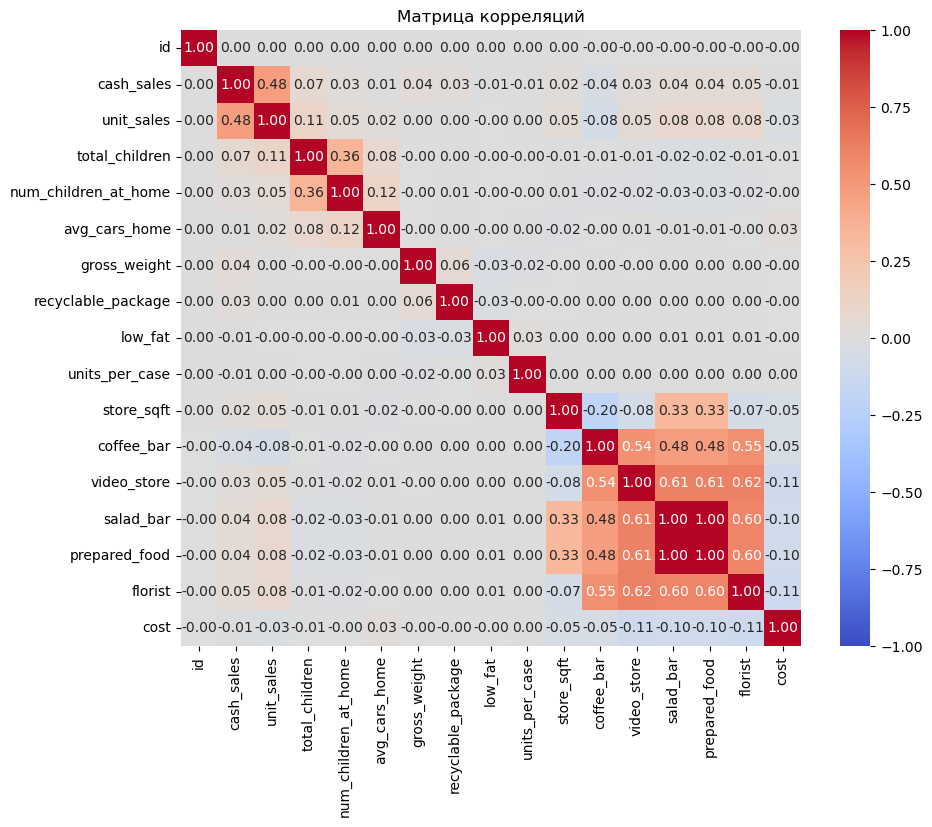

In [5]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляций')
plt.show()

Выводы:
- id, gross_weight, num_children_at_home,recyclable_package,low_fat, units_per_case удаляю из за отсутвия корреляции с cost
- salad_bar, prepared_food сильная положительная корреляция между собой. Удаляю salad_bar,что бы избежать мультиколлериальности

In [ ]:
# Удаление столбцов которые не влияют на cost
df = df.drop(columns=['id', 'gross_weight', 'num_children_at_home','recyclable_package', 'units_per_case', 'low_fat', 'salad_bar' ])

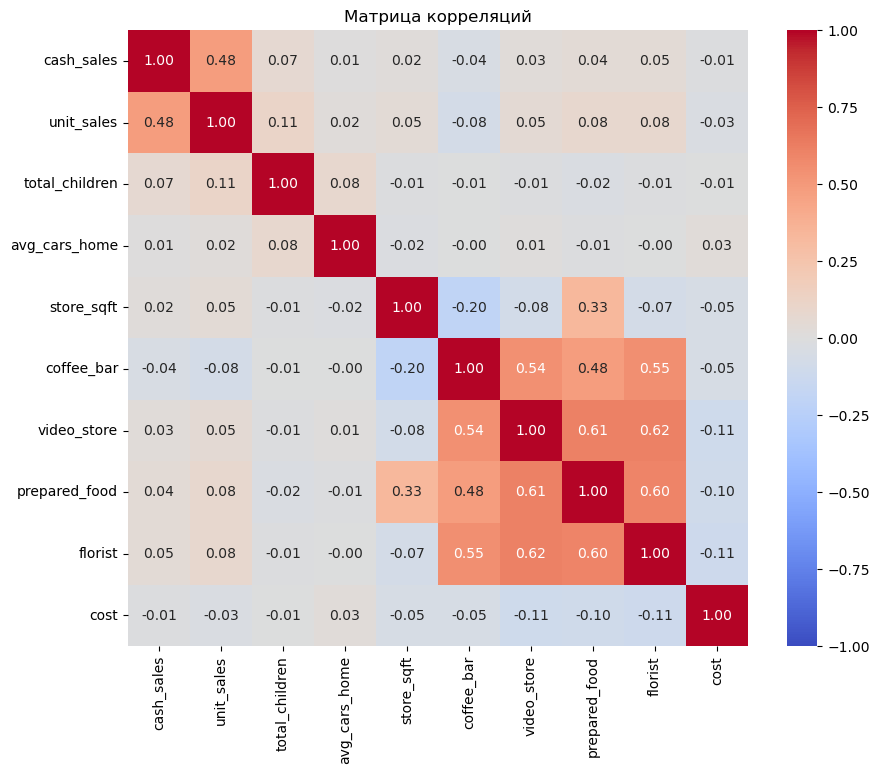

In [7]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляций')
plt.show()

EDA-анализ

In [8]:
eda_df = return_eda(df)
eda_df

,nan,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,,
cash_sales,0,0.0,22.92,0.51,6.337376,5.78,1.094273e+01,2.32,11.04,3.72,8.40,356907,float64,1044,0,0,3442
unit_sales,0,0.0,6.00,1.00,3.043881,3.00,6.157163e-01,2.00,4.00,3.00,4.00,0,float64,6,0,6765,31
total_children,0,0.0,5.00,0.00,2.456482,2.00,2.217097e+00,0.00,4.00,1.00,4.00,0,float64,6,36441,0,0
avg_cars_home,0,0.0,4.00,0.00,2.203813,2.00,1.175692e+00,1.00,4.00,1.00,3.00,0,float64,5,18537,0,0
store_sqft,0,0.0,39696.00,20319.00,28180.333442,27694.00,3.562746e+07,21215.00,38382.00,23593.00,33858.00,0,float64,20,0,0,0
coffee_bar,0,0.0,1.00,0.00,0.564839,1.00,2.457965e-01,0.00,1.00,0.00,1.00,0,float64,2,156804,0,0
video_store,0,0.0,1.00,0.00,0.277394,0.00,2.004471e-01,0.00,1.00,0.00,1.00,0,float64,2,260381,0,0
prepared_food,0,0.0,1.00,0.00,0.504832,1.00,2.499773e-01,0.00,1.00,0.00,1.00,0,float64,2,178427,0,0
florist,0,0.0,1.00,0.00,0.503191,1.00,2.499905e-01,0.00,1.00,0.00,1.00,0,float64,2,179018,0,0


Выводы:
- пропусков нет
- есть выбросы в полях cash_sales, unit_sales
- требуется масштабирование перед обучением
- у части полей можно поменять типы данных на int
- unit_sales - имеет всего 6 значений

In [9]:
# Меняю типы данных
# Проходим по строкам eda_df, где "Дробные" равно 0
for parameter in eda_df[eda_df['Дробные'] == 0].index:
    df[parameter] = df[parameter].astype(int)

Работа с выбросами

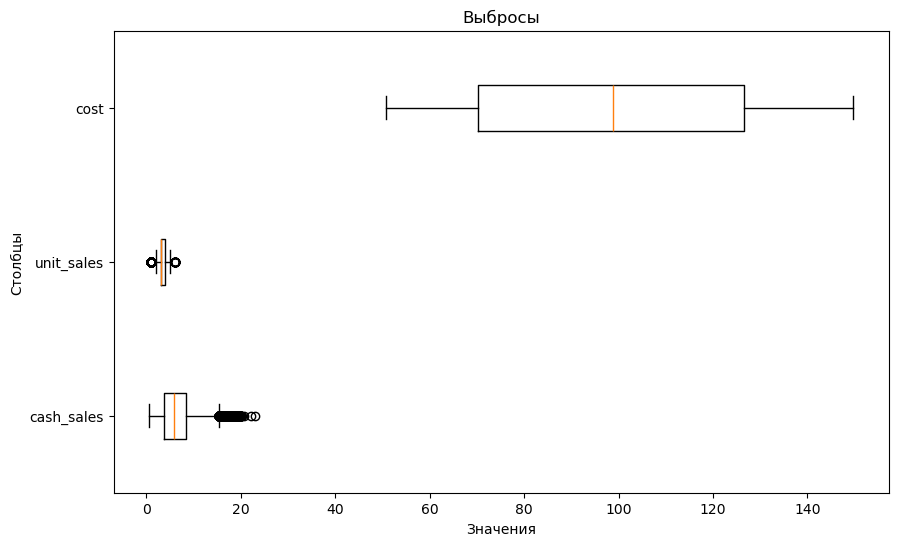

In [10]:
# Посмотрим на выбросы
df_filtered = df[['cash_sales', 'unit_sales', 'cost']] # Столбцы в ручную  переделать на eda_df
return_boxplot(df_filtered, 'Выбросы').show()

Удаляю выбросы

In [11]:
# cash_sales
Q1 = df['cash_sales'].quantile(0.25)  
Q3 = df['cash_sales'].quantile(0.75)  
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['cash_sales'] >= lower_bound) & (df['cash_sales'] <= upper_bound)]

# unit_sales
Q1 = df['unit_sales'].quantile(0.25)
Q3 = df['unit_sales'].quantile(0.75)
IQR = Q3 - Q1 

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['unit_sales'] >= lower_bound) & (df['unit_sales'] <= upper_bound)]

# вывод результата
df_filtered = df[['cash_sales', 'unit_sales', 'cost']]
eda_df = return_eda(df_filtered)
eda_df

,nan,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,,
cash_sales,0,0.0,15.40,0.52,6.319413,5.82,9.908645,2.40,10.92,3.81,8.34,346716,float64,846,0,0,1133
unit_sales,0,0.0,5.00,2.00,3.071118,3.00,0.534814,2.00,4.00,3.00,4.00,0,int32,4,0,0,0
cost,0,0.0,149.75,50.79,99.492983,98.81,901.154014,59.02,140.90,69.65,126.62,346977,float64,328,0,0,0


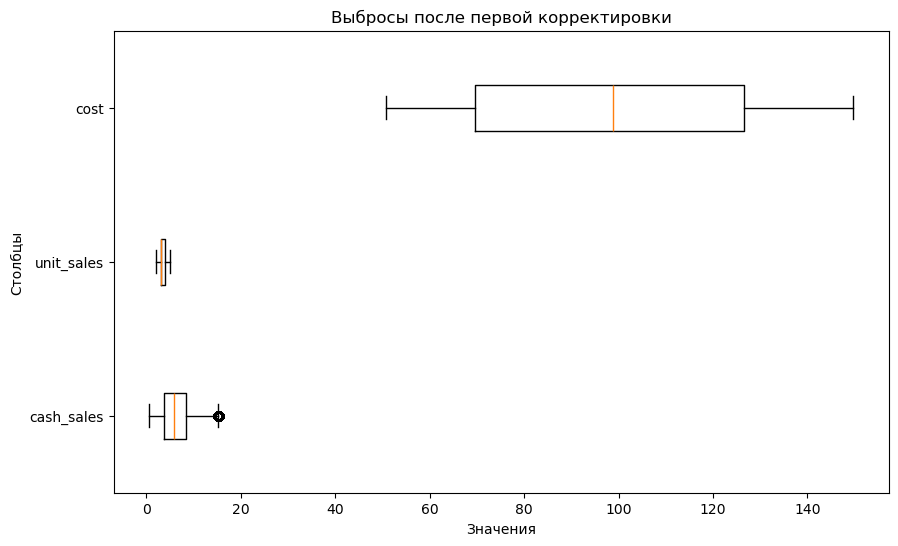

In [12]:
# График
return_boxplot(df_filtered,'Выбросы после первой корректировки').show()

In [13]:
# cash_sales появились выбросы по верхней границе. Заменю на верхний уровень
Q1 = df['cash_sales'].quantile(0.25)
Q3 = df['cash_sales'].quantile(0.75)

IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['cash_sales'] = df['cash_sales'].clip(upper=upper_bound)

# вывод результата
df_filtered = df[['cash_sales', 'unit_sales', 'cost']]
eda_df = return_eda(df_filtered)
eda_df


,nan,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,,
cash_sales,0,0.0,15.135,0.52,6.318890,5.82,9.899324,2.40,10.92,3.81,8.34,346716,float64,840,0,0,0
unit_sales,0,0.0,5.000,2.00,3.071118,3.00,0.534814,2.00,4.00,3.00,4.00,0,int32,4,0,0,0
cost,0,0.0,149.750,50.79,99.492983,98.81,901.154014,59.02,140.90,69.65,126.62,346977,float64,328,0,0,0


Вывод:
- выбросы устранены
- store_sqft большой диапазон. Переведу в большие единицы измерения

In [14]:
# ------------А так можно???---------
# Приведу store_sqft и cost к другим единицам измерения
df['store_sqft'] = df['store_sqft'] / 10000
df['cost'] = df['cost'] / 100
df['cash_sales'] = df['cash_sales'] / 10

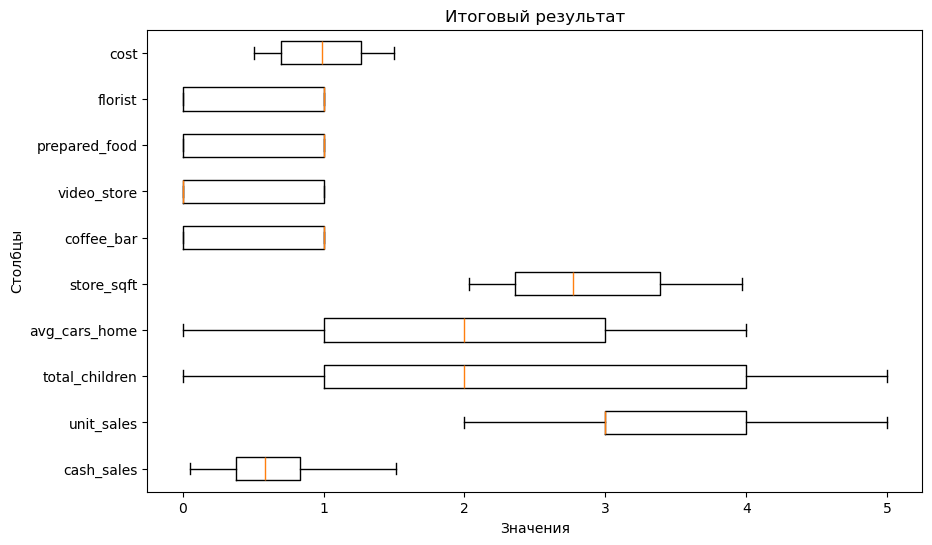

In [15]:
return_boxplot(df, 'Итоговый результат').show()

Общие выводы по данным:
- учитывая почти полное отсутсвие линейных зависимостей между переменными и целью, алгоритм линейной регрессии не применим к этому набору данных, без его преобразования.
- сильная корреляция "сервисных" служб (preparatio_food, video_store итп) между собой. Попробую сделать PCA
- unit_sales скорее ранжированная категориальная переменная чем чмсло. В качестве эксперимента попробую Target Encoding
- в успех модели я не верю, не хватает знаний преобразовать данные

In [16]:
# target_encoding для unit_sales к cost
# Вычисление среднего значение cost для каждого уникального значения unit_sales
target_encoding = df.groupby('unit_sales')['cost'].mean().to_dict()

# Замена unit_sales на соответствующие средние значения cost
df['unit_sales_encoded'] = df['unit_sales'].map(target_encoding)

# print(df[['unit_sales', 'unit_sales_encoded']].head())

In [17]:
features = ['coffee_bar', 'video_store',  'prepared_food', 'florist']
X = df[features]

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)  # Уменьшаем до 2 компонент
X_pca = pca.fit_transform(X_scaled)

# print("Объяснённая дисперсия каждой компоненты:", pca.explained_variance_ratio_)
# print("Суммарная объяснённая дисперсия:", sum(pca.explained_variance_ratio_))

# Добавление в  DataFrame
df['PCA_1'] = X_pca[:, 0]  # Первая компонента
df['PCA_2'] = X_pca[:, 1]  # Вторая компонента

# print(df[['PCA_1', 'PCA_2']].head())

In [18]:

# Выделяем целевую переменную и признаки
# X = df[['unit_sales_encoded', 'cash_sales', 'store_sqft']]  # Признаки
X = df[['unit_sales_encoded', 'store_sqft', 'PCA_1', 'PCA_2']]
f_ = X
# X = df[[ 'store_sqft', 'PCA_1']]
y = df['cost']  # Целевая переменная

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# Константа для statsmodels (для intercept)
X_scaled = sm.add_constant(X_scaled)

# Разделение данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Регрессия с помощью statsmodels (OLS)
model_sm = sm.OLS(y_train, X_train).fit()  # Обучаем модель
# print(model_sm.summary())  # Выводим статистику модели

# Регрессия с помощью scikit-learn
model_sk = LinearRegression()
model_sk.fit(X_train, y_train)  # Обучаем модель (первый столбец это константа)

# Предсказания
y_pred_sm = model_sm.predict(X_test)  # Предсказания для statsmodels
y_pred_sk = model_sk.predict(X_test)  # Предсказания для scikit-learn

# Оценка качества модели
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE в процентах
    r2 = r2_score(y_true, y_pred)  # R² (коэффициент детерминации)

    print(f"Метрики для модели {model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"R²: {r2:.4f}")

# Оценим модели
evaluate_model(y_test, y_pred_sm, "Statsmodels OLS")
evaluate_model(y_test, y_pred_sk, "Scikit-Learn Linear Regression")

Метрики для модели Statsmodels OLS:
MAE: 0.2566
MSE: 0.0886
RMSE: 0.2976
MAPE: 29.8262%
R²: 0.0160
Метрики для модели Scikit-Learn Linear Regression:
MAE: 0.2566
MSE: 0.0886
RMSE: 0.2976
MAPE: 29.8262%
R²: 0.0160


Вывод:
- модели дают одинаковые метрики, они идентичны
- Модели не оптимальны. Дают большие погрешности и судя по R2 не могут объяснить зависимости между перменными

In [19]:
# Выгружаем коэффициенты модели
coefficients = model_sk.coef_

# Выгружаем intercept (свободный член)
intercept = model_sk.intercept_

print("Коэффициенты модели:", coefficients)
print("Intercept (свободный член):", intercept)

Коэффициенты модели: [ 0.          0.00386371 -0.01145508 -0.03333442  0.00707853]
Intercept (свободный член): 0.9950033533169075


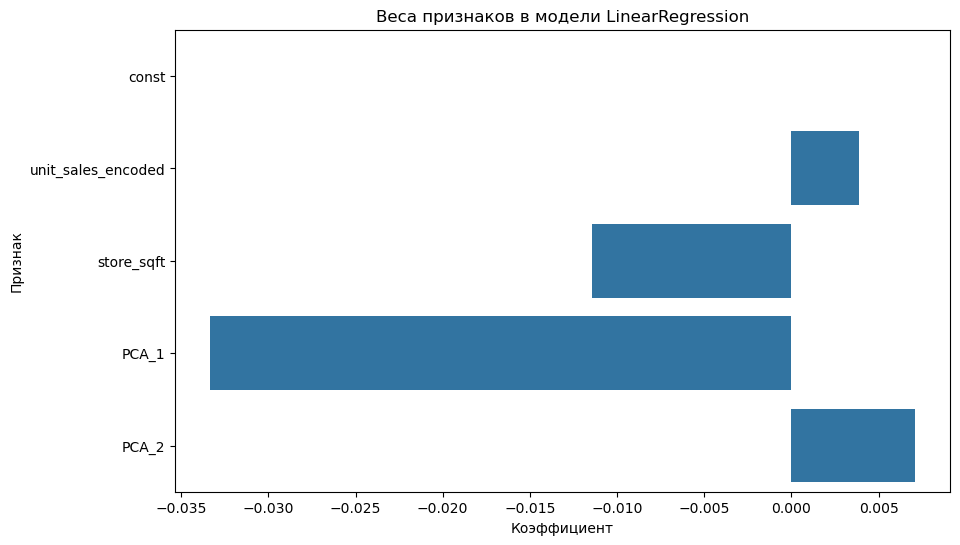

In [20]:
feature_names = ['const', 'unit_sales_encoded', 'store_sqft', 'PCA_1', 'PCA_2']

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Веса признаков в модели LinearRegression')
plt.xlabel('Коэффициент')
plt.ylabel('Признак')
plt.show()

Вывод: 
- MAE = 0.2566 учитывая диапазон ошибка составляет примерно 17%
- MSE = 0.0886 небольшыя
- RMSE  = 0.2976 примерно 30% от диапазона. Большая ошибка
- MAPE = 29.8262% Модель пдохо справляется с предсказаниями
- R² = 0.0160 стремиться к 0. Слабая предсказательная способность


### Модель неудовлетворительная!